In [51]:
import ipywidgets as widgets
from ipywidgets import interact, SelectMultiple, fixed, Checkbox, IntRangeSlider, IntSlider, FloatSlider
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import plotly.express as px
import plotly.graph_objects as go
import copy
from tqdm.autonotebook import tqdm
from PIL import Image
from scipy import stats
from matplotlib.image import NonUniformImage
from src.DataExtractor import DataExtractor


data_extractor = DataExtractor()

In [52]:
# cut the image
im = Image.open(r'../figures/nhl_rink.png')
width, height = im.size

new_w = width/2
im_new = im.crop((new_w, 0, width, height))

new_width, height = im_new.size

In [53]:
year = 2017
df_season_league = data_extractor.get_season_into_dataframe('./hockey/Season' + str(year) + str(year + 1) + '/season' + str(year) + str(year + 1) + '.json')

In [54]:
def __generate_combined_shots_per_hour(df_season_league: pd.DataFrame, team_ids: list):
    total_shot_count = 0
    total_league_time_played_in_minutes = 0
    
    for team_id in tqdm(team_ids, total = len(team_ids)):
        team_season_shots_x, team_season_shots_y = data_extractor.get_team_shots_from_dataframe(df_season_league, team_id)
        total_shot_count += len(team_season_shots_x)
        
        team_season_time = data_extractor.get_time_played_from_team_season_dataframe(df_season_league, team_id)
        total_league_time_played_in_minutes += np.sum(team_season_time)
    
    total_league_time_played_in_hours = total_league_time_played_in_minutes / 60
    return total_shot_count / total_league_time_played_in_hours

    
def calculate_league_shots_per_hour(df_season_league: pd.DataFrame) -> float:
    team_ids = list(range(1,56))
    return __generate_league_shots_per_hour(df_season_league, team_ids)


def calculate_team_shots_per_hour(df_season_league: pd.DataFrame, team_id: int) -> float:
    team_ids = [team_id]
    return __generate_league_shots_per_hour(df_season_league, team_ids)


def __generate_total_shots_array(df_season_league: pd.DataFrame, team_ids: list):
    total_shots_x = np.array([])
    total_shots_y = np.array([])
    
    for team_id in tqdm(team_ids, total = len(team_ids)):
        team_season_shots_x, team_season_shots_y = data_extractor.get_team_shots_from_dataframe(df_season_league, team_id)
        total_shots_x = np.append(total_shots_x, team_season_shots_x)
        total_shots_y = np.append(total_shots_y, team_season_shots_y)
        
    return total_shots_x, total_shots_y


def get_total_league_shots_array(df_season_league: pd.DataFrame):
    team_ids = list(range(1,56))
    return __generate_total_shots_array(df_season_league, team_ids)


def get_total_team_shots_array(df_season_league: pd.DataFrame, team_id: int):
    team_ids = [team_id]
    return __generate_total_shots_array(df_season_league, team_ids)


def get_time_played_for_teams(df_season_league: pd.DataFrame, team_ids: list):
    total_league_time_played_in_minutes = 0
    
    for team_id in tqdm(team_ids, total = len(team_ids)):
        team_season_time = data_extractor.get_time_played_from_team_season_dataframe(df_season_league, team_id)
        total_league_time_played_in_minutes += np.sum(team_season_time)
        
    return total_league_time_played_in_minutes / 60


def get_team_info(df: pd.DataFrame, team_id: int):
    df.rename(columns={
        'team.id': 'teamID', 
        'team.name': 'teamName'
        }, inplace=True)
    
    df = df[df.teamID == team_id]
    name = df.teamName
    team_id = df.teamID
    if name.empty:
        return ('rien', -1)
    return (name.iloc[0], team_id.iloc[0])
    

In [55]:
def compute_team_shots_excess_by_hour_for_team(df_season_league: pd.DataFrame, team_id: int, source, width: float, lenght: float):
    ##
    # rink = [-100,100] * [-42.5, 42.5]
    # image =  [0,550] * [0,467]
    ###
    #transformation
    ratio_w = width / 100
    ratio_l = lenght / 85

    total_team_shots_x, total_team_shots_y = get_total_team_shots_array(df_season_league, team_id)
    total_team_shots_x = np.abs(total_team_shots_x * ratio_w)
    total_team_shots_y = (total_team_shots_y+42.5) * ratio_l
    
    total_league_shots_x, total_league_shots_y = get_total_league_shots_array(df_season_league)
    total_league_shots_x = np.abs(total_league_shots_x * ratio_w)
    total_league_shots_y = (total_league_shots_y+42.5) * ratio_l
    
    time_played_by_team = get_time_played_for_teams(df_season_league, [team_id])
    time_played_by_league = get_time_played_for_teams(df_season_league, list(range(1,56)))
    
    # put shots in bins
    xedges = list(range(0, new_width+1, 25))
    yedges = list(range(0, height+1, 25))
    H_team, xedges, yedges = np.histogram2d(total_team_shots_x, total_team_shots_y, bins=(xedges, yedges))
    H_league, xedges, yedges = np.histogram2d(total_league_shots_x, total_league_shots_y, bins=(xedges, yedges))

    # Histogram does not follow Cartesian convention (see Notes),
    # therefore transpose H for visualization purposes.
    H_team = H_team.T
    H_league = H_league.T
    
    H_team = H_team / time_played_by_team
    H_league = H_league / time_played_by_league
    shot_excess = H_team - H_league
    return shot_excess, xedges, yedges

In [56]:
shot_excess, xedges, yedges = compute_team_shots_excess_by_hour_for_team(df_season_league, 4, im_new, new_width, height)
shot_excess_2, xedges_2, yedges_2 = compute_team_shots_excess_by_hour_for_team(df_season_league, 5, im_new, new_width, height)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

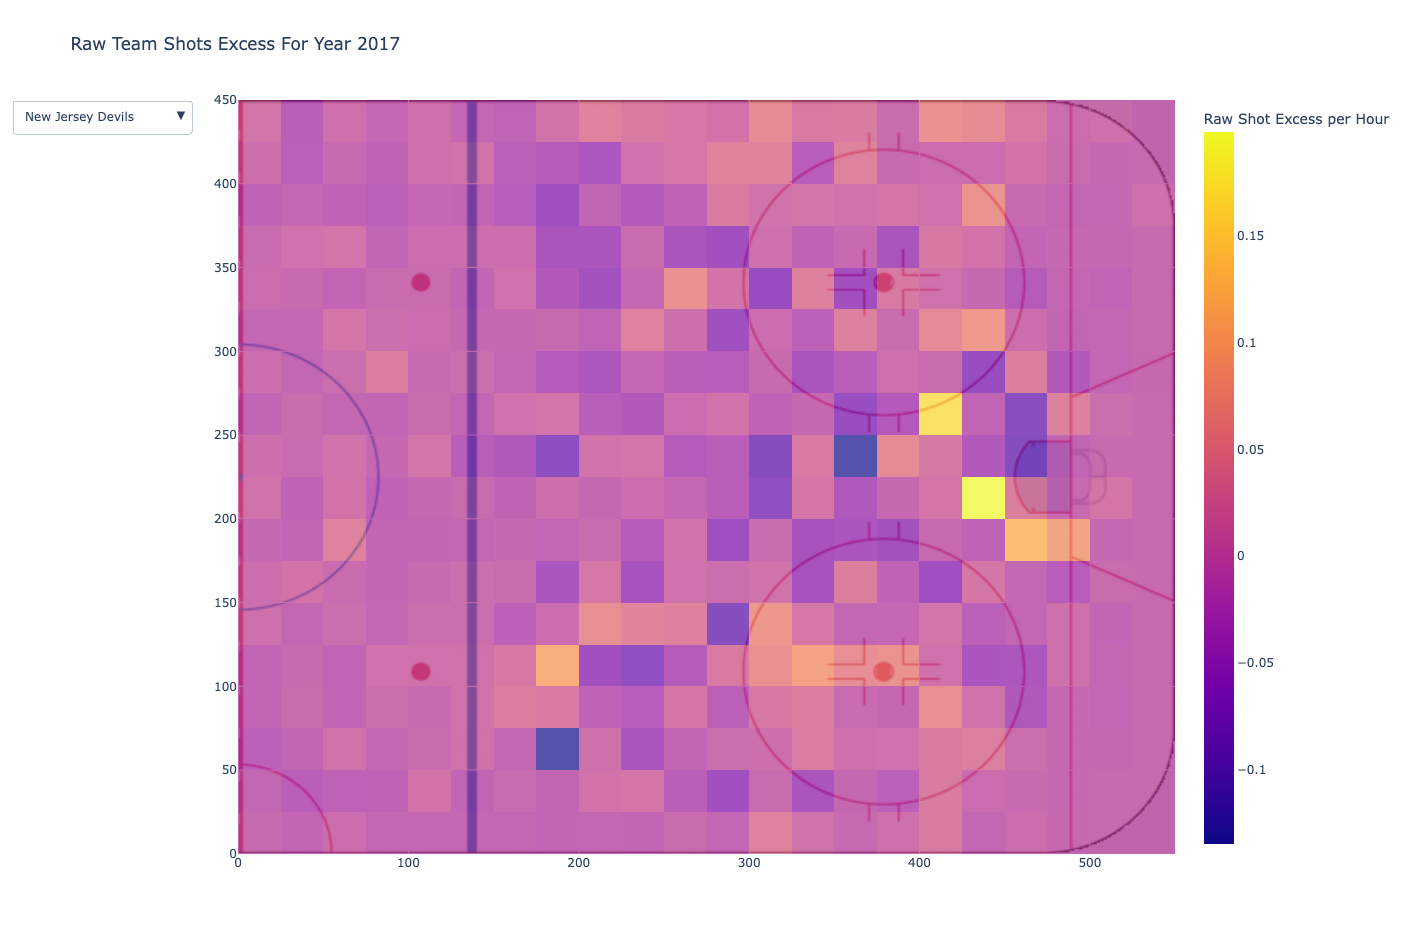

In [57]:
source = im_new
fig = go.Figure()
year = 2017
df_season_league = data_extractor.get_season_into_dataframe('./hockey/Season' + str(year) + str(year + 1) + '/season' + str(year) + str(year + 1) + '.json')

false_list = []
teams_names = []
teams_ids = []

for i in range(1,56):
    team_name, team_id = get_team_info(df_season_league, i)
    if team_name == 'rien':
        continue
    teams_names.append(team_name)
    teams_ids.append(team_id)
    false_list.append(False)

array_dict = []
for i in range(0, len(teams_ids)):
    shot_excess, xedges, yedges = compute_team_shots_excess_by_hour_for_team(df_season_league, teams_ids[i], im_new, new_width, height)
    if (i == 0):
        fig.add_trace(go.Heatmap(x=xedges, y=yedges, z=shot_excess, opacity=0.7, colorbar=dict(title='Raw Shot Excess per Hour'),  name=str(i+1)))
    else:
        fig.add_trace(go.Heatmap(x=xedges, y=yedges, z=shot_excess, visible=False, opacity=0.7, colorbar=dict(title='Raw Shot Excess per Hour'), name=str(i+1)))
        
    false_list[i] = True
    array_dict.append(dict(label=teams_names[i],
                 method="update",
                 args=[{"visible": copy.deepcopy(false_list)}]))
    false_list[i] = False
    
fig.update_layout(
    updatemenus=[
    dict(
        active=0,
        buttons=list(array_dict),
        )
    ]
    
)
fig.update_layout(
    width=new_width * 2,
    height = height * 2,
    title="Raw Team Shots Excess For Year " + str(year)
)

fig.add_layout_image(
        source=source,
        xref="paper",
        yref="paper",
        x=0,
        y=1,
        xanchor="left",
        yanchor="top",
        layer="below",
        sizing="stretch",
        sizex=1.0,
        sizey=1.0
)

fig.show()
#fig.write_html("2017.html")